In [8]:
%pylab inline
from libanalysis import PhantomAnalysis as pa

Populating the interactive namespace from numpy and matplotlib


Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.


39709


(-172.02078654892105,
 14.790305914468792,
 -325.8540276810263,
 18.60198812528028)

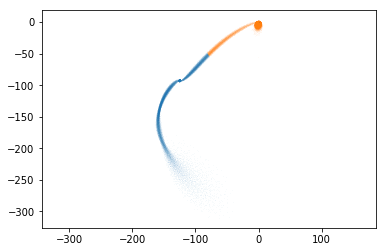

In [37]:
def in_range(dump, R):
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    
    r = np.sqrt(x**2 + y**2 + z**2)
    return r <= R

def inter_ep(dump):
    
def get_bound(dump, Mb):
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    ep = -Mb/r
    
    vx = dump.vxyz[0]
    vy = dump.vxyz[1]
    vz = dump.vxyz[2]
    
    ek = 0.5*(vx**2 + vy**2 + vz**2)
    
    return ep+ek < 0
    
b = get_bound(dump,10)

print(b.sum())

plt.scatter(dump.xyzh[0][~b],dump.xyzh[1][~b],s=0.0001)
plt.scatter(dump.xyzh[0][b],dump.xyzh[1][b],s=0.0001)
plt.axis('equal')

In [80]:
prefix = '../low_N/rp09/'

idx = np.linspace(0,750,76)

times =[]
boundn=[]
for i in idx:
    fname = 'tde_%05d'% i
    print(fname)
    dump = pa(prefix+fname)
    times.append(dump.time * dump.units['utime'])
    
    boundn.append(dump.massofgas*(get_bound(dump, 10)).sum() )



tde_00000
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00010
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00020
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00030
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00040
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00050
Unable to 

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00520
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00530
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00540
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00550
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00560
Unable to load uterm

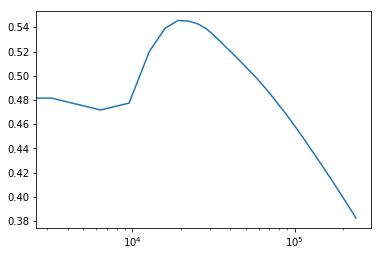

In [81]:
def get_dot(t, b):
    
    m_dot = (b[1::] - b[0:-1])/(t[1::] - t[0:-1])
    t = 0.5*(t[1::] + t[0:-1])
    return t, m_dot



plt.plot(np.array(times), np.array(boundn))
plt.xscale('log')
#plt.yscale('log')
#plt.xlim([2e4,2e5])
